In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from math import log10, floor
import os
import glob
import matplotlib.pyplot as plt
import datetime
from math import ceil, isnan
import sys
try:
    import torchtext
    from torchtext.data import Field, Iterator, Dataset, Example
except ImportError: 
    !{'/opt/anaconda3/bin/python3'} -m pip install --upgrade git+https://github.com/pytorch/text
    import torchtext
    from torchtext.data import Field, Iterator, Dataset

from relational_rnn_models import RelationalMemoryGenerator
from discriminator import RelGANDiscriminator

cuda = torch.cuda.is_available()

# Try setting the device to a GPU
device = torch.device("cuda:0" if cuda else "cpu")
print('Device:', device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Device: cuda:0


In [14]:
# Helper function(s)

# round a number to n significant digits
def round_to_n(x, n = 2):
    return round(x, -int(floor(log10(abs(x)))) + (n - 1)) if x != 0 else 0

# Transform a date string into a datetime object
def str_to_datetime(string):
    return datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

# TODO: more complex reduction: takes into account different ICD groups?
def reduce_icd(icd_full):
    return icd_full[:2]

def get_distribution(data, field, vocab_size, fake = True):
    counts = torch.zeros(vocab_size - 2)

    for i in range(2, vocab_size):
        if fake:
            counts[i - 2] = torch.sum(data == i)
        else:
            counts[i - 2] = field.vocab.freqs[field.vocab.itos[i]]

    freqs = counts / torch.sum(counts)
    
    return counts, freqs
    

In [53]:
%%time

filename = 'data/FINNGEN_ENDPOINTS_DF3_longitudinal_V1_for_SandBox.txt.gz'

endpoints = ['I9_HYPTENS', 'I9_ANGINA', 'I9_HEARTFAIL_NS', 'I9_STR_EXH', 'I9_CHD']

events = pd.read_csv(filename, compression = 'infer', sep='\t', nrows = 9_000_000)

print(events.columns)

# include all endpoints in a list
events = events[events['ENDPOINT'].isin(endpoints)]
events = events.groupby('FINNGENID').filter(lambda x: len(x) > 1)

subjects = events['FINNGENID'].unique()
n_individuals = len(subjects)
print(n_individuals)
print(events['ENDPOINT'].unique())

Index(['FINNGENID', 'EVENT_AGE', 'EVENT_YEAR', 'ENDPOINT'], dtype='object')
2724
['I9_HYPTENS' 'I9_HEARTFAIL_NS' 'I9_ANGINA' 'I9_CHD' 'I9_STR_EXH']
CPU times: user 6.94 s, sys: 60 ms, total: 7 s
Wall time: 6.72 s


In [54]:
%%time

print(events.groupby('FINNGENID').apply(lambda x: x['EVENT_AGE'].max() - x['EVENT_AGE'].min()).describe())
print(events.groupby('FINNGENID').apply(lambda x: len(x)).describe())

count    2724.000000
mean       10.896098
std        11.033168
min         0.000000
25%         0.927500
50%         7.930000
75%        17.425000
max        47.610000
dtype: float64
count    2724.000000
mean       13.969163
std        19.872855
min         2.000000
25%         3.000000
50%         6.000000
75%        16.000000
max       273.000000
dtype: float64
CPU times: user 680 ms, sys: 4 ms, total: 684 ms
Wall time: 682 ms


In [55]:
max_sequence_length = 5

sequence_length = min(events.groupby('FINNGENID').apply(lambda x: len(x)).max(), max_sequence_length)
print(sequence_length)

def get_sequence_of_codes(subject):
    codes = []
    
    count = 0
    for i in subject.sort_values('EVENT_AGE').index:
        codes.append(subject.loc[i, 'ENDPOINT'])
        count += 1
        if count == sequence_length:
            break
        
    res = ' '.join(codes)
    return res

def get_sequence_of_time_differences(subject):
    times = [0]
    
    count = 0
    for i in subject.sort_values('EVENT_AGE').index:
        times.append(subject.loc[i, 'EVENT_AGE'])
        count += 1
        if count == sequence_length:
            break
        
    res = np.diff(times)
    return res
    

5


In [56]:
%%time

sequences_of_codes = events.groupby('FINNGENID').apply(get_sequence_of_codes)
#print(sequences_of_codes.head())
print(sequences_of_codes.apply(lambda x: len(x.split(' '))).describe())
print(sequences_of_codes.shape)

sequences_of_times = events.groupby('FINNGENID').apply(get_sequence_of_time_differences)
#print(sequences_of_times.head())
print(sequences_of_times.apply(lambda x: len(x)).describe())
print(sequences_of_times.shape)

count    2724.000000
mean        4.071219
std         1.237524
min         2.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000
dtype: float64
(2724,)
count    2724.000000
mean        4.071219
std         1.237524
min         2.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000
dtype: float64
(2724,)
CPU times: user 4 s, sys: 28 ms, total: 4.03 s
Wall time: 3.96 s


In [57]:
#sequences = pd.DataFrame({'ENDPOINTS': sequences_of_codes.stack(), 'TIME_DIFFS': sequences_of_times.stack()})
sequences = pd.DataFrame({'ENDPOINTS': sequences_of_codes, 'TIME_DIFFS': sequences_of_times})
print(sequences.shape)
#sequences.head()


(2724, 2)


In [58]:
# https://stackoverflow.com/questions/52602071/dataframe-as-datasource-in-torchtext

class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""
    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.fields = dict(fields)
        self.examples = examples.apply(SeriesExample.fromSeries, args=(self.fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""
    
    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()
        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [59]:
%%time

tokenize = lambda x: x.split(' ')

ENDPOINT = Field(fix_length = sequence_length, tokenize = tokenize)

fields = [('ENDPOINTS', ENDPOINT), ('TIME_DIFFS', None)]

train_sequences, val_sequences = train_test_split(sequences, test_size = 0.1)
print(train_sequences.shape, val_sequences.shape)

train = DataFrameDataset(train_sequences, fields)
val = DataFrameDataset(val_sequences, fields)

ENDPOINT.build_vocab(train, val)

(2451, 2) (273, 2)
CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 99.7 ms


In [60]:
print(ENDPOINT.vocab.stoi['ANY_ATC'])
print(ENDPOINT.vocab.itos[2])
vocab_size = len(ENDPOINT.vocab.freqs) + 2
print(vocab_size)

print(ENDPOINT.vocab.freqs[ENDPOINT.vocab.itos[3]])


0
I9_HYPTENS
7
2688


In [61]:
val_iter = Iterator(val, batch_size = len(val_sequences), repeat = True)

next(iter(val_iter)).ENDPOINTS.transpose(0, 1).shape

torch.Size([273, 5])

In [129]:
%%time

def get_transition_matrix(data, vocab_size = vocab_size, d = 1, eps = 1e-20):
    transition_count = torch.zeros(vocab_size - 1, vocab_size - 1)

    for indv in data:
        for idx in range(len(indv) - d):
            i1 = idx
            i2 = i1 + d
            ep1 = indv[i1]
            ep2 = indv[i2]
            if ep1 > 0 and ep2 > 0:
                transition_count[ep1 - 1, ep2 - 1] += 1
                    
    #print(torch.sum(transition_count, dim = 1))
    transition_freq = (transition_count.transpose(0, 1) / (torch.sum(transition_count, dim = 1) + eps)).transpose(0, 1)
                    
    return transition_count, transition_freq
        
iterator = Iterator(train, batch_size = len(train_sequences))

transition_count, transition_freq = get_transition_matrix(next(iter(iterator)).ENDPOINTS.transpose(0, 1), vocab_size, d = 1)    
print(transition_count)
print(transition_freq)
print(transition_freq.sum(dim = 1))


tensor([[1296.,    0.,    0.,    0.,    0.,    0.],
        [ 607., 2703.,  368.,  194.,  167.,  128.],
        [ 149.,  168., 1471.,   45.,   40.,   22.],
        [  42.,  178.,   76.,  433.,  255.,   23.],
        [ 139.,   76.,   95.,  215.,  320.,   13.],
        [  54.,  118.,   28.,   10.,    9.,  362.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1457, 0.6487, 0.0883, 0.0466, 0.0401, 0.0307],
        [0.0786, 0.0887, 0.7763, 0.0237, 0.0211, 0.0116],
        [0.0417, 0.1768, 0.0755, 0.4300, 0.2532, 0.0228],
        [0.1620, 0.0886, 0.1107, 0.2506, 0.3730, 0.0152],
        [0.0929, 0.2031, 0.0482, 0.0172, 0.0155, 0.6231]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
CPU times: user 704 ms, sys: 0 ns, total: 704 ms
Wall time: 703 ms


In [125]:
%%time

iterator = Iterator(train, batch_size = len(train_sequences))

transition_count1, transition_freq1 = get_transition_matrix(next(iter(iterator)).ENDPOINTS.transpose(0, 1), vocab_size, d = 1)    
transition_count2, transition_freq2 = get_transition_matrix(next(iter(val_iter)).ENDPOINTS.transpose(0, 1), vocab_size, d = 1)    

print(transition_freq1)
print(transition_freq2)


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1457, 0.6487, 0.0883, 0.0466, 0.0401, 0.0307],
        [0.0786, 0.0887, 0.7763, 0.0237, 0.0211, 0.0116],
        [0.0417, 0.1768, 0.0755, 0.4300, 0.2532, 0.0228],
        [0.1620, 0.0886, 0.1107, 0.2506, 0.3730, 0.0152],
        [0.0929, 0.2031, 0.0482, 0.0172, 0.0155, 0.6231]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1483, 0.6441, 0.0975, 0.0466, 0.0318, 0.0318],
        [0.0569, 0.0995, 0.7820, 0.0142, 0.0332, 0.0142],
        [0.0714, 0.1339, 0.0982, 0.4464, 0.2143, 0.0357],
        [0.0722, 0.0928, 0.1237, 0.2887, 0.3918, 0.0309],
        [0.1429, 0.2222, 0.0952, 0.0000, 0.0000, 0.5397]])
CPU times: user 740 ms, sys: 0 ns, total: 740 ms
Wall time: 737 ms


In [16]:
subjects = sequences.index
n_individuals = len(subjects)
print(n_individuals)
print(vocab_size / (n_individuals * sequence_length)) # The lower this is the easier it is for the generator to learn

292
0.004794520547945206


In [17]:
# Test generator output

mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

start_token = torch.tensor([[0]])
memory = G.initial_state(batch_size = 1)

if cuda:
    G.cuda()
    start_token = start_token.cuda()
    memory = memory.cuda()

print(memory)
logits, tokens, _, memory = G(start_token, memory, sequence_length, None)
print(logits)
print(tokens)
print(memory)


tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], device='cuda:0')
tensor([[[1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1.]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[0, 3, 4, 2, 6]], device='cuda:0')
tensor([[[ 0.9680,  0.9800,  0.9856, -0.9201],
         [-0.1218,  2.8154,  1.0216, -0.9665],
         [-0.7889,  0.0210,  0.9495, -1.2685],
         [-0.8723,  0.1495,  0.7579, -0.4874]]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [136]:
%%time

# Define generator evaluation function

def chi_sqrd_dist(counts1, counts2, separate = False, eps = 1e-20):
    counts1 = counts1.view(1, -1)
    counts2 = counts2.view(1, -1)
    table = torch.cat([counts1, counts2], dim = 0)
    col_sums = torch.sum(table, dim = 0)
    row_sums = torch.sum(table, dim = 1)
    n = torch.sum(col_sums)
    
    table_freq = table / (n + eps)
    col_freqs = col_sums / (n + eps)
    row_freqs = row_sums / (n + eps)
    
    diffs = table_freq[0, :] / (row_freqs[0] + eps) - table_freq[1, :] / (row_freqs[1] + eps)
    diffs_sqrd = diffs ** 2
    diffs_sqrd_norm = diffs_sqrd / (col_freqs + eps)
    
    if separate: 
        return diffs_sqrd_norm
    
    chi_sqrd_distance = torch.sum(diffs_sqrd_norm)
    
    return chi_sqrd_distance

def get_fake_distribution(G, start_tokens, vocab_size = vocab_size, sequence_length = sequence_length):
    memory = G.initial_state(batch_size = start_tokens.shape[0])

    if cuda:
        memory = memory.cuda()
        start_tokens = start_tokens.cuda()
    
    _, data_fake, _, _ = G(start_tokens, memory, sequence_length)
    
    counts_fake, freqs_fake = get_distribution(data_fake, None, vocab_size, fake = True)
    
    return counts_fake, freqs_fake
    
def get_score(G, ENDPOINT, start_tokens, vocab_size = vocab_size, sequence_length = sequence_length):
    counts_real, freqs_real = get_distribution(None, ENDPOINT, vocab_size, fake = False)
    
    counts_fake, freqs_fake = get_fake_distribution(G, start_tokens, vocab_size, sequence_length)
    
    score = chi_sqrd_dist(counts_real, counts_fake)
    return score

def get_transition_score(G, iterator, d = 1, separate = False, vocab_size = vocab_size, sequence_length = sequence_length):
    data = next(iter(iterator)).ENDPOINTS.transpose(0, 1)
    transition_count_real, transition_freq_real = get_transition_matrix(data, vocab_size, d)
    
    start_tokens = data[:, :1]
    memory = G.initial_state(batch_size = start_tokens.shape[0])

    if cuda:
        memory = memory.cuda()
        start_tokens = start_tokens.cuda()
    
    _, data_fake, _, _ = G(start_tokens, memory, sequence_length)
    
    transition_count_fake, transition_freq_fake = get_transition_matrix(data_fake, vocab_size, d)
    
    chi_sqrd_ds = []
    for i in range(vocab_size - 1):
        chi_sqrd_d = chi_sqrd_dist(transition_count_fake[i, :], transition_count_real[i, :])
        chi_sqrd_ds.append(chi_sqrd_d)
        
    chi_sqrd_ds = torch.tensor(chi_sqrd_ds)
    
    if separate:
        return chi_sqrd_ds
        
    return torch.mean(chi_sqrd_ds)
    
def get_aggregate_transition_score(G, iterator, separate1 = True, separate2 = True, vocab_size = vocab_size, sequence_length = sequence_length):
    scores = []
    for d in range(1, sequence_length):
        transition_score = get_transition_score(G, iterator, d, separate1, vocab_size, sequence_length)
        scores.append(transition_score)
        
    result = torch.stack(scores)
    
    if separate2:
        return result
    
    if separate1:
        return torch.mean(result, dim = 0)
    else:
        return torch.mean(result)

val_data = next(iter(val_iter)).ENDPOINTS.transpose(0, 1)

score = get_score(G, ENDPOINT, val_data[:, :1])
print(score)

transition_score = get_transition_score(G, val_iter, d = 1, separate = True)
print(transition_score)

aggr_transition_score = get_aggregate_transition_score(G, val_iter, True, True)
print(aggr_transition_score)


tensor(0.2866)
tensor([3.1389, 0.8352, 0.6095, 1.1570, 1.0620, 1.2653])
tensor([[3.1441, 1.0423, 0.5093, 1.2882, 1.7576, 0.8656],
        [3.2633, 0.8028, 0.4078, 0.7016, 0.9656, 1.1810],
        [1.0000, 0.8937, 0.5181, 0.9012, 0.8851, 1.2257],
        [0.0000, 1.3153, 0.6881, 1.1076, 1.2478, 1.8617]])
CPU times: user 1.72 s, sys: 84 ms, total: 1.8 s
Wall time: 1.8 s


In [137]:
# Test Discriminator output

n_embeddings = 2
embed_size = 2
out_channels = 5 
filter_sizes = [2, 3] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    D.cuda()

inp = logits
print(inp)
print(D(inp, False))
print(D(inp))


tensor([[[1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1.]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[0.5334, 0.5360]], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([0.5347], device='cuda:0', grad_fn=<MeanBackward2>)


In [138]:
# Define the generator pre-train function

def pretrain_generator(G, train, batch_size, vocab_size, sequence_length, n_epochs, lr, print_step = 10):
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    
    if cuda:
        G.cuda()
        loss_function.cuda()
    
    for e in range(n_epochs):
        train_iter = Iterator(train, batch_size = batch_size, device = device)
        loss_total = 0
        count = 0
        
        for batch in train_iter:
            train_data = batch.ENDPOINTS.transpose(0, 1)
            train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)
            
            start_token = train_data[:, :1]
            optimizer.zero_grad()

            memory = G.initial_state(batch_size = train_data.shape[0])

            if cuda:
                start_token = start_token.cuda()
                memory = memory.cuda()
                
            logits, _, _, _ = G(start_token, memory, sequence_length, 1.0)

            loss = loss_function(logits, train_data_one_hot)
            
            loss_total += loss.item()
            count += 1

            loss.backward()
            optimizer.step()
            
        
        if e % print_step == 0:
            print(
                "[Epoch %d/%d] [G loss: %f]"
                % (e, n_epochs, loss_total / count)
            )

In [141]:
mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

if cuda:
    G.cuda()
    
val_data = next(iter(val_iter)).ENDPOINTS.transpose(0, 1)

score = get_score(G, ENDPOINT, val_data[:, :1])
print(score)
aggr_transition_score = get_aggregate_transition_score(G, val_iter, True, True)
print(aggr_transition_score)
print(aggr_transition_score.mean())

batch_size = 64
pretrain_generator(G, train, batch_size, vocab_size, sequence_length, 3, 0.01, print_step = 1)

score = get_score(G, ENDPOINT, val_data[:, :1])
print(score)
aggr_transition_score = get_aggregate_transition_score(G, val_iter, True, True)
print(aggr_transition_score)
print(aggr_transition_score.mean())

tensor(1.0517)
tensor([[2.6775, 1.7927, 3.0756, 0.9194, 1.1843, 0.5255],
        [2.8474, 1.2431, 2.5402, 0.8238, 0.8632, 0.4192],
        [1.0000, 1.8853, 2.7281, 0.8546, 1.4770, 1.0496],
        [0.0000, 1.5297, 3.1180, 1.6377, 1.1606, 0.8302]])
tensor(1.5076)
[Epoch 0/3] [G loss: 4.963276]
[Epoch 1/3] [G loss: 4.680381]
[Epoch 2/3] [G loss: 4.432643]
tensor(0.0463)
tensor([[1.9547, 0.1288, 0.6756, 1.2380, 1.2744, 1.1568],
        [1.3756, 0.1237, 0.6926, 0.3972, 0.7317, 0.5800],
        [1.0000, 0.1924, 0.7463, 0.5740, 0.5379, 0.5989],
        [0.0000, 0.1259, 0.5886, 0.8571, 1.7288, 1.0424]])
tensor(0.7634)


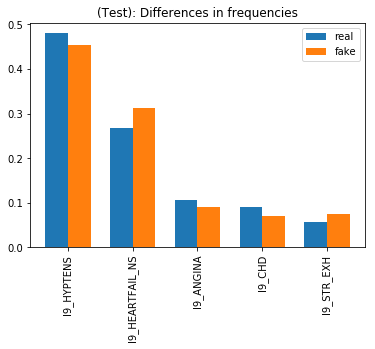

In [25]:
def save_grouped_barplot(freqs, freqs_fake, idx, title, N=10):
    freqs1 = freqs.numpy()[idx]
    freqs2 = freqs_fake.numpy()[idx]

    fig, ax = plt.subplots(figsize=(6,6))

    ind = np.arange(N)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, freqs1, width, bottom=0)

    p2 = ax.bar(ind + width, freqs2, width, bottom=0)

    ax.set_title(title)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(map(lambda x: ENDPOINT.vocab.itos[x], idx + 2), rotation=90)

    ax.legend((p1[0], p2[0]), ('real', 'fake'))
    ax.autoscale_view()
    
    fig.subplots_adjust(bottom=0.36)
    fig.savefig('figs/' + '_'.join(title.split(' ')).translate({ord(i): None for i in ':()'}) + '.svg')
    
def save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix='', N_max=10):
    N = min(N_max, vocab_size - 2)
    if not prefix == '':
        prefix += ' '
    
    if N == vocab_size - 2:
        idx = np.arange(N)
        
        title = prefix + 'Differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)
    else:
        abs_diffs = np.abs(freqs - freqs_fake)
        idx = np.argsort(abs_diffs)[-N:]
        idx = np.flip(idx)
        
        title = prefix + 'Largest absolute differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)

        chi_sqrd_dists = chi_sqrd_dist(counts, counts_fake, separate = True)
        idx = np.argsort(chi_sqrd_dists)[-N:]
        idx = np.flip(idx)

        title = prefix + 'Largest relative differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)
    

train_iter = Iterator(train, batch_size = len(train_sequences))
train_data = next(iter(train_iter)).ENDPOINTS.transpose(0, 1)
    
counts, freqs = get_distribution(None, ENDPOINT, vocab_size, fake = False)
counts_fake1, _ = get_fake_distribution(G, val_data[:, :1])
counts_fake2, _ = get_fake_distribution(G, train_data[:, :1])

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

N_max = 10
prefix = '(Test):'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)

In [165]:
# Define the training function

def get_scores(G, ENDPOINT, iterator, separate1 = True, separate2 = True, vocab_size = vocab_size, sequence_length = sequence_length):
    start_tokens = next(iter(iterator)).ENDPOINTS.transpose(0, 1)[:, :1]
    
    score1 = get_score(G, ENDPOINT, start_tokens, vocab_size, sequence_length)
    
    score2 = get_aggregate_transition_score(G, iterator, separate1, separate2, vocab_size, sequence_length)
    
    return score1, score2.mean(), score2

def train_GAN(G, D, train, val_iter, batch_size, vocab_size, sequence_length, \
              n_epochs, lr, temperature, print_step = 10, score_fn = get_scores):    
    scores = []
    
    score = score_fn(G, ENDPOINT, val_iter)
    print('Score before training:', *score)
    scores.append(score)
    
    print('pretraining generator...')
    pretrain_generator(G, train, batch_size, vocab_size, sequence_length, max(n_epochs // 10, 1), \
                       lr * 100, print_step = max(n_epochs // 10 - 1, 1))
    print('pretraining complete')
    
    score = score_fn(G, ENDPOINT, val_iter)
    print("[Score:", *score, "]")
    scores.append(score)
    
    adversarial_loss = torch.nn.BCELoss()
    
    optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)
    
    if cuda:
        G.cuda()
        D.cuda()
        adversarial_loss.cuda()
    
    for e in range(n_epochs):
        train_iter = Iterator(train, batch_size = batch_size, device = device)
        #loss_total = 0
        #count = 0
        
        for batch in train_iter:
            train_data = batch.ENDPOINTS.transpose(0, 1)
            train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)

            start_token = train_data[:, :1]
            
            # Adversarial ground truths
            valid = Variable(Tensor(train_data.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(train_data.shape[0], 1).fill_(0.0), requires_grad=False)

            optimizer_G.zero_grad()

            # Generate a batch of images
            memory = G.initial_state(batch_size = train_data.shape[0])
            if cuda:
                memory = memory.cuda()

            temp = temperature ** ((e + 1) / n_epochs)
            fake_one_hot, _, _, _ = G(start_token, memory, sequence_length, temp)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(D(fake_one_hot).view(-1), valid.view(-1))

            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(D(train_data_one_hot).view(-1), valid.view(-1))
            fake_loss = adversarial_loss(D(fake_one_hot.detach()).view(-1), fake.view(-1))
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        if e % print_step == 0:
            print(
                "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
                % (e, n_epochs, d_loss.item(), g_loss.item())
            )
            score = score_fn(G, ENDPOINT, val_iter)
            print("[Score:", *score, "]")
            scores.append(score)
            
    score = score_fn(G, ENDPOINT, val_iter)
    print('Score after training:', *score)
    scores.append(score)
            
    new_scores = [[] for _ in range(len(scores[0]))]
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            new_scores[j].append(scores[i][j])

    for j in range(len(scores[0])):
        new_scores[j] = torch.stack(new_scores[j])
            
    return tuple(new_scores)


Score before training: tensor(0.2807) tensor(1.2047) tensor([[3.6169, 1.0382, 1.6364, 0.8024, 0.7107, 1.1098],
        [3.1970, 0.8182, 1.3465, 0.5647, 0.9516, 1.2418],
        [1.0000, 0.8583, 1.1557, 0.2342, 0.5637, 1.9036],
        [0.0000, 0.9417, 1.2206, 0.5306, 0.8950, 2.5746]])
pretraining generator...
[Epoch 0/1] [G loss: 4.638664]
pretraining complete
[Score: tensor(0.0370) tensor(0.7802) tensor([[1.4191, 0.2391, 0.6003, 1.1346, 1.2273, 1.3668],
        [1.2177, 0.2543, 0.3704, 0.8205, 0.8409, 1.5917],
        [1.0000, 0.3200, 0.3039, 0.5023, 0.7554, 1.6465],
        [0.0000, 0.2680, 0.3802, 0.2275, 0.7422, 1.4960]]) ]
[Epoch 0/3] [D loss: 0.697582] [G loss: 0.608724]
[Score: tensor(0.0225) tensor(0.7217) tensor([[1.3042, 0.1742, 0.6248, 0.9399, 1.2652, 1.5642],
        [1.0887, 0.1563, 0.2311, 0.9023, 1.0684, 1.1486],
        [1.0000, 0.1293, 0.2690, 0.4438, 0.5758, 0.9214],
        [0.0000, 0.3819, 1.0213, 0.1501, 0.9523, 1.0069]]) ]
[Epoch 1/3] [D loss: 0.695565] [G loss: 0

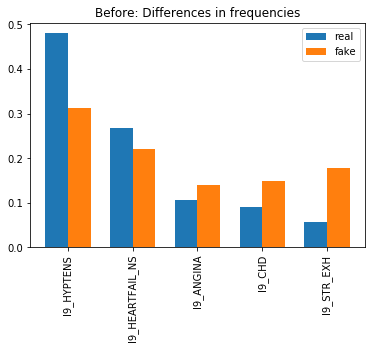

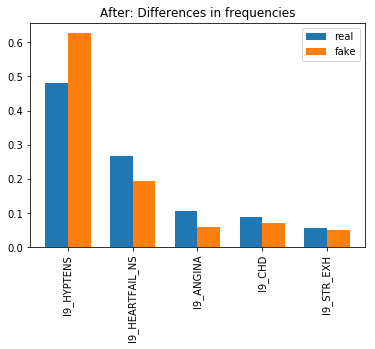

In [166]:
# Train the GAN

start_time = time.time()

# Generator params
mem_slots = 1
head_size = 6
embed_size = 10
temperature = 5
num_heads = 10
num_blocks = 6

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads, num_blocks)

# Discriminator params
n_embeddings = 5
embed_size = embed_size
out_channels = 15
filter_sizes = [2, 3, 4] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    G.cuda()
    D.cuda()

counts_fake1, _ = get_fake_distribution(G, val_data[:, :1])
counts_fake2, _ = get_fake_distribution(G, train_data[:, :1])

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

N_max = 10
prefix = 'Before:'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)



batch_size = 64
n_epochs = 3
print_step = max(n_epochs // 10, 1)
lr = 1e-4

# Train the GAN
scores1, scores2, scores3 = train_GAN(G, D, train, val_iter, batch_size, vocab_size, sequence_length, n_epochs, lr, temperature, print_step)



counts_fake1, _ = get_fake_distribution(G, val_data[:, :1])
counts_fake2, _ = get_fake_distribution(G, train_data[:, :1])

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

prefix = 'After:'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)

print('Time taken:', round_to_n(time.time() - start_time, n = 3), 'seconds')


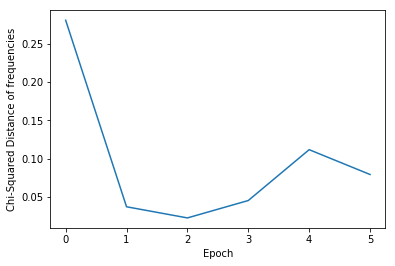

In [167]:
%matplotlib inline

plt.plot(range(scores1.shape[0]), scores1.numpy())
plt.ylabel('Chi-Squared Distance of frequencies')
plt.xlabel('Epoch')
plt.savefig('figs/chisqrd_freqs.svg')

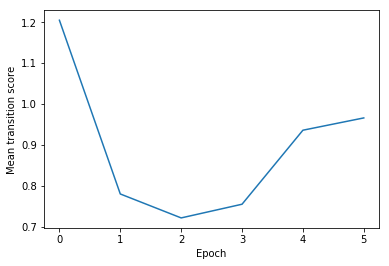

In [168]:
plt.plot(range(scores2.shape[0]), scores2.numpy())
plt.ylabel('Mean transition score')
plt.xlabel('Epoch')
plt.savefig('figs/mean_transition_score.svg')

In [176]:
for d in range(1, sequence_length):
    plt.plot(range(scores3.shape[0]), scores3[:, d - 1, :].numpy())
    plt.ylabel('Transition score')
    plt.xlabel('Epoch')
    title = 'd=' + str(d)
    plt.title(title)
    labels = [ENDPOINT.vocab.itos[i] for i in range(1, vocab_size)]
    plt.legend(labels)
    plt.savefig('figs/' + title + '.svg')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [177]:
for v in range(1, vocab_size):
    plt.plot(range(scores3.shape[0]), scores3[:, :, v - 1].numpy())
    plt.ylabel('Transition score')
    plt.xlabel('Epoch')
    title = 'enpoint=' + ENDPOINT.vocab.itos[v]
    plt.title(title)
    labels = ['d=' + str(i) for i in range(1, sequence_length)]
    plt.legend(labels)
    plt.savefig('figs/' + title + '.svg')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [178]:
test_size = 5
start_tokens = torch.randint(2, vocab_size, (test_size, 1))
print(start_tokens)

memory = G.initial_state(batch_size = test_size)

if cuda:
    memory = memory.cuda()
    start_tokens = start_tokens.cuda()
    
_, data_fake, _, _ = G(start_tokens, memory, sequence_length)

data_fake

tensor([[6],
        [4],
        [5],
        [6],
        [3]])


tensor([[6, 2, 6, 2, 2],
        [4, 5, 2, 2, 3],
        [5, 5, 2, 2, 2],
        [6, 5, 2, 1, 3],
        [3, 5, 1, 2, 1]], device='cuda:0')